In [71]:
%pip install --user sklearn
%pip install --user numpy
%pip install --user pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [12]:
def confusion_matrix(model, X, y):
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in range(0, len(X)):

            pred = model.predict(X[i].reshape(1, -1))[0]

            if pred == 1 and y[i] == 1:
                tp+=1
            elif pred == 1 and y[i] == 0:
                fp+=1
            elif pred == 0 and y[i] == 0:
                tn+=1
            else:
                fn+=1
        labels = "True Positive", "False Positive", "True Negative", "False Negative"
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
        plt.pie([tp,fp,tn,fn], labels=labels, colors=colors, autopct='%1.1f%%')
        plt.show()
        
        return tp, fp, tn, fn

def count_occurences(y):
    ones=0
    zeroes=0
    
    for i in range(0,len(y)):
        if y[i] == 1:
            ones+=1
        else:
            zeroes+=1
    return ones, zeroes

In [4]:
data_matrix = np.loadtxt(open("./msd_genre_dataset/msd_genre_dataset_segpreproc_knime.csv", "rb"), delimiter=";", skiprows=1)

#Los datos del set de datos están agrupados por género. Es decir, primero están todas las filas que corresponden
#a 1 y después todas las que corresponden a 0. Se hace un shuffle para que, más tarde, en cross-validation
#no se creen unos modelos que predigan únicamente una clase.
X = np.random.shuffle(data_matrix)

print("Filas de la matriz: " + str(len(data_matrix)))
print("Columnas de la matriz: " + str(len(data_matrix[0])))

X = np.resize(data_matrix, (len(data_matrix), len(data_matrix[0])-1))
y = data_matrix[:,len(data_matrix[0])-1]

#Se intenta estandarizar X para lograr mejor desempeño. Sin embargo, no parece funcionar.
X = MinMaxScaler().fit_transform(X)

print("X shape" + str(X.shape))
print("y shape" + str(y.shape))

Filas de la matriz: 8350
Columnas de la matriz: 31
X shape(8350, 30)
y shape(8350,)


Hacer doble click sobre la gráfica para hacer zoom.

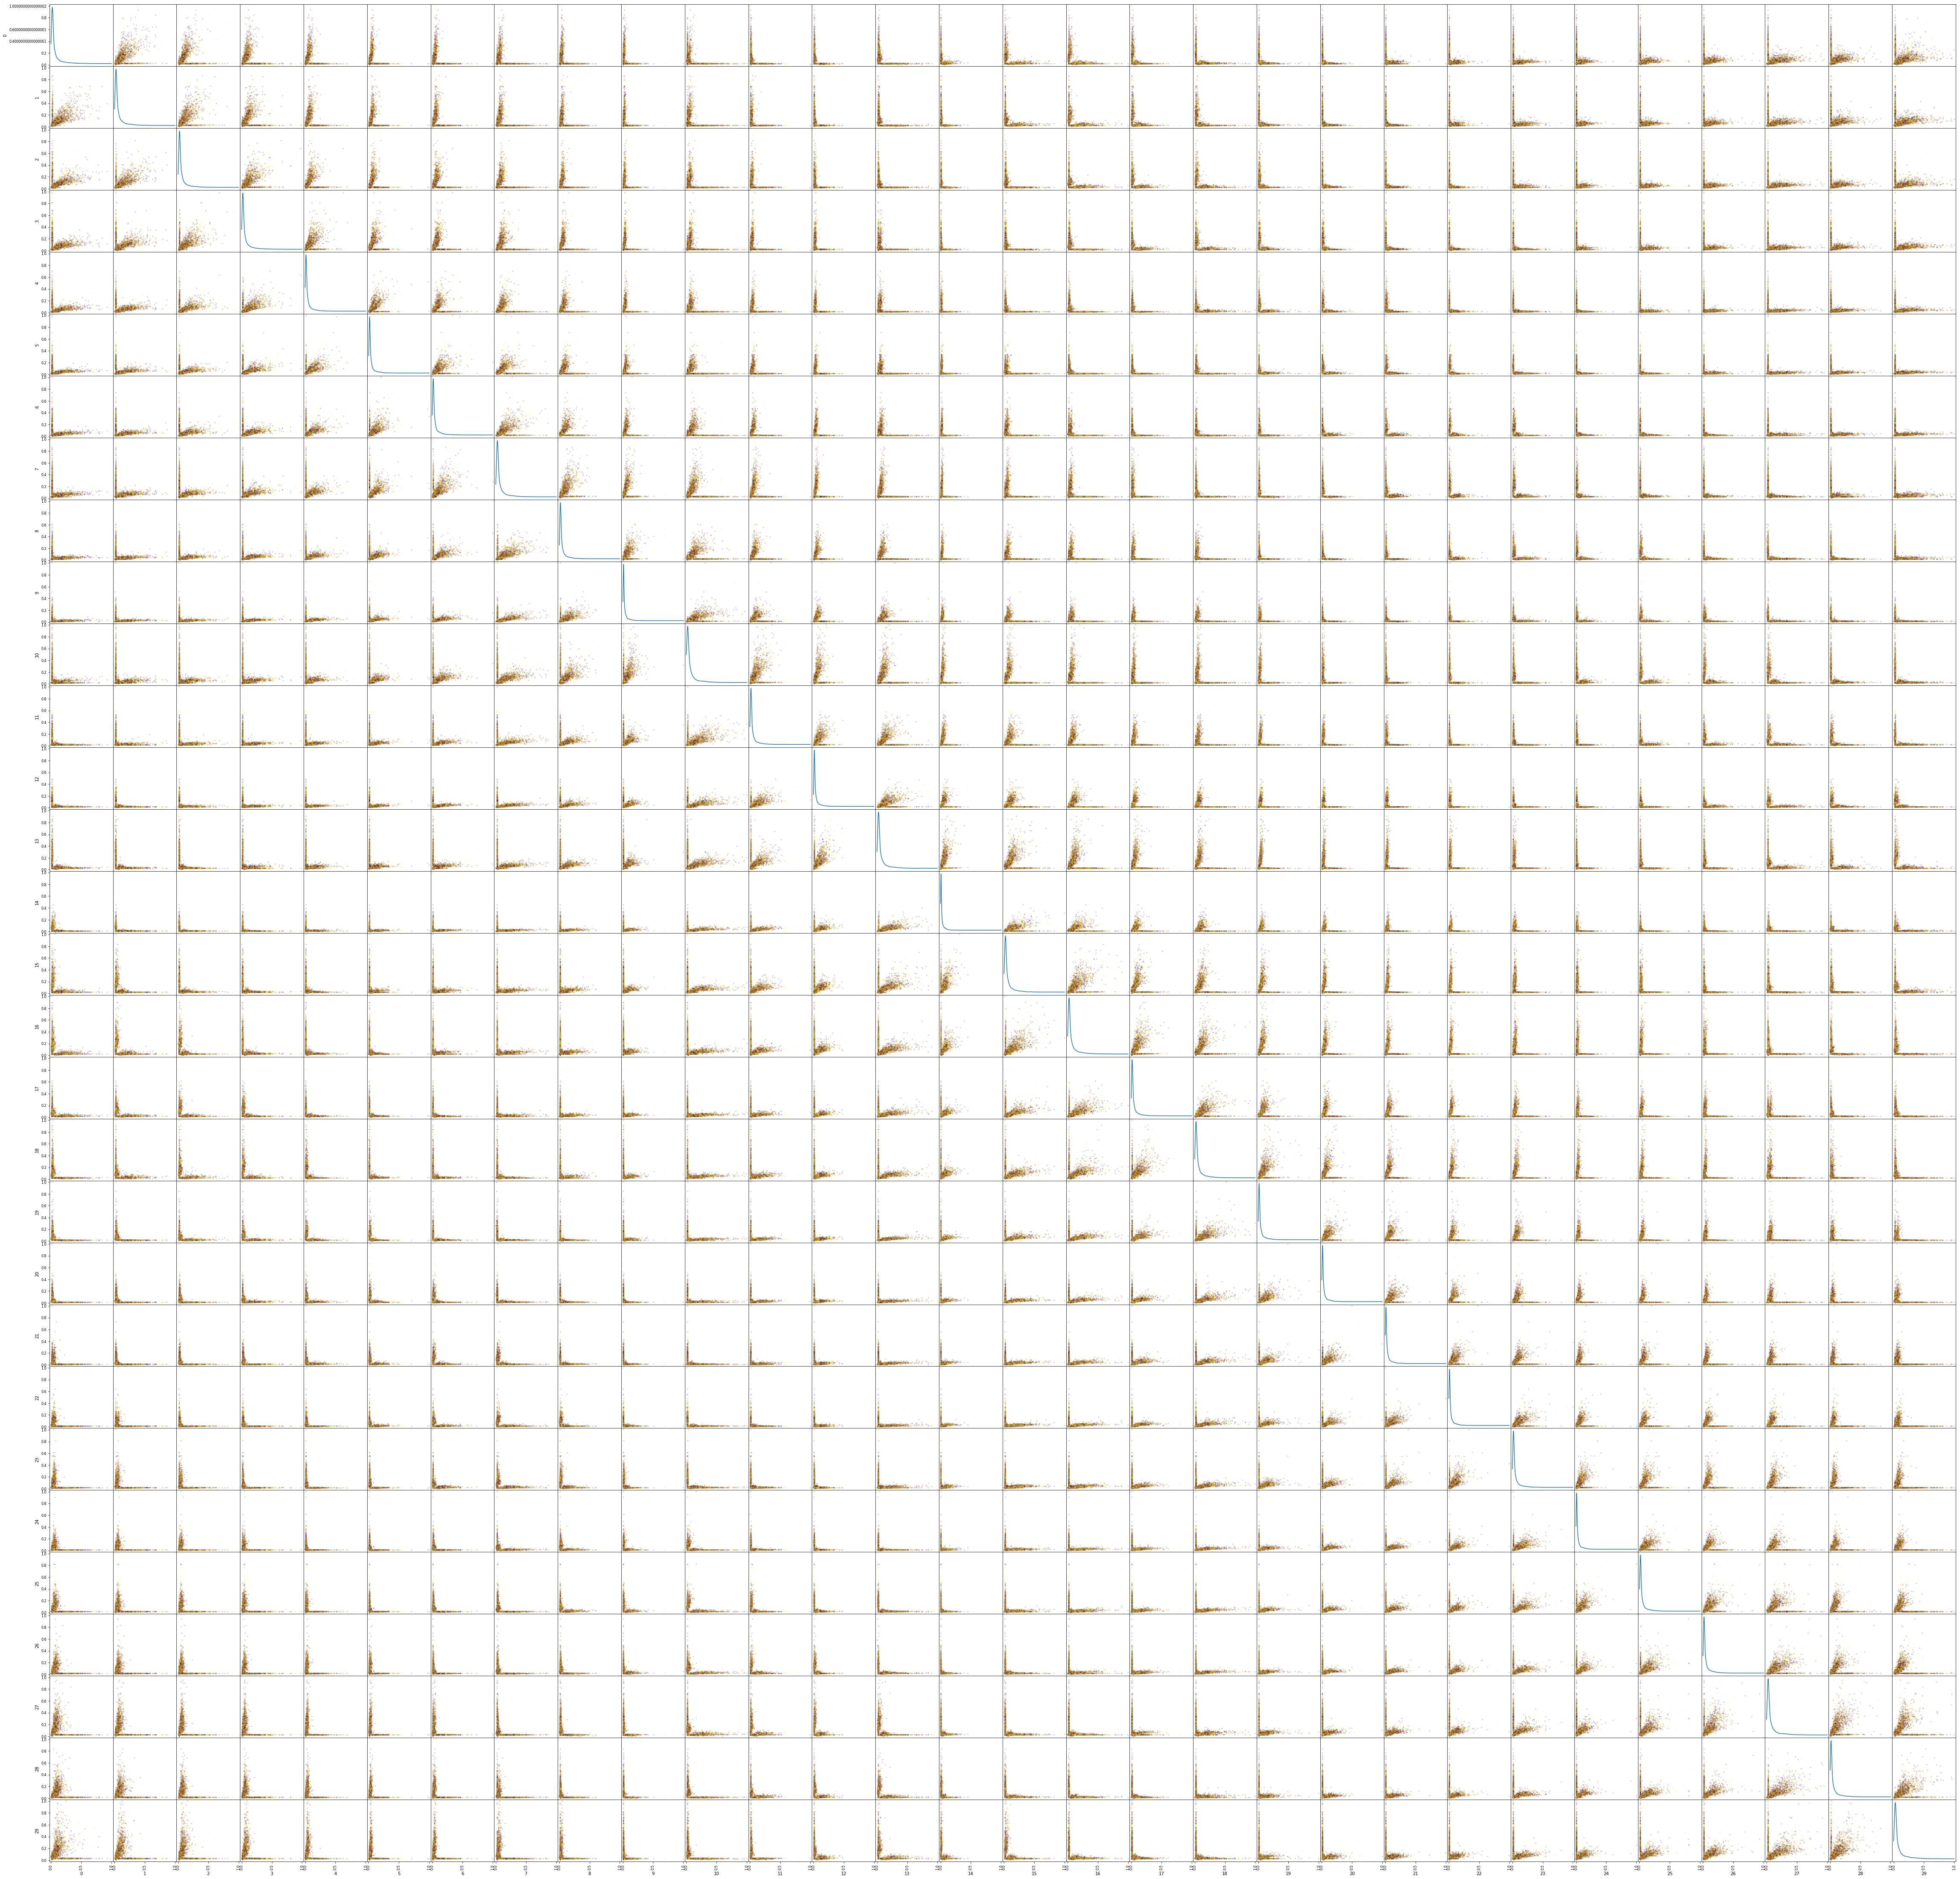

In [9]:
import pandas as pd
from pandas.plotting import scatter_matrix

scatter_matrix(pd.DataFrame(X), alpha=0.2, figsize=(80, 80), diagonal='kde', c=y)
plt.show()

In [5]:
percentage_test = 0.2

#Porcentaje de datos dedicados a validación, relativo al número de datos de test
percentage_validation = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage_test) 

ones: 3474| zeroes: 3206


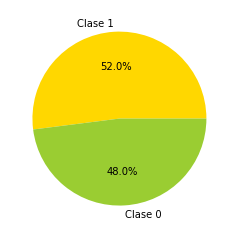

In [11]:
one, zero = count_occurences(y_train)

print("ones: %s| zeroes: %s" % (one, zero))

labels = "Clase 1", "Clase 0"
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie([one, zero], labels= labels, colors=colors, autopct='%1.1f%%')
plt.show()

In [22]:
kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 100
scores = []
best_neurons=0
best_score=1

for n in range(2, n_max+1, 5):

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_validate = X_train[train_index], X_train[test_index]
        y_train_cv, y_validate = y_train[train_index], y_train[test_index]
        net = MLPClassifier(solver='sgd',hidden_layer_sizes=(n,), activation = "relu", 
                            alpha=0, learning_rate_init = 0.01)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_neurons = n
    
    print("Average error probability for %s neurons in one hidden layer: %s" % (n, score))

print("Lowest error probability: %s for model with %s neurons" % (best_score, best_neurons))

Average error probability for 2 neurons in one hidden layer: 0.4799401197604791
Average error probability for 7 neurons in one hidden layer: 0.4835329341317365
Average error probability for 12 neurons in one hidden layer: 0.4847305389221558
Average error probability for 17 neurons in one hidden layer: 0.48263473053892214
Average error probability for 22 neurons in one hidden layer: 0.48158682634730543
Average error probability for 27 neurons in one hidden layer: 0.4806886227544911
Average error probability for 32 neurons in one hidden layer: 0.48368263473053896
Average error probability for 37 neurons in one hidden layer: 0.48547904191616764
Average error probability for 42 neurons in one hidden layer: 0.47964071856287427
Average error probability for 47 neurons in one hidden layer: 0.4875748502994012
Average error probability for 52 neurons in one hidden layer: 0.482185628742515
Average error probability for 57 neurons in one hidden layer: 0.48158682634730543
Average error probability

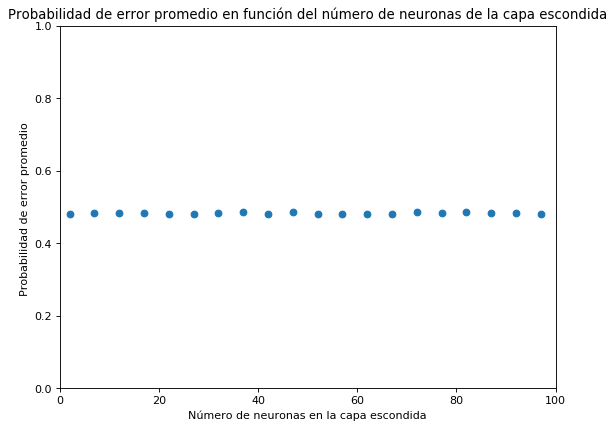

In [23]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(2, n_max, 5), scores, 'o')
plt.axis([0, 100, 0, 1])
plt.xlabel('Número de neuronas en la capa escondida')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número de neuronas de la capa escondida')
plt.show()

Probabilidad de error del modelo con 42 neuronas en una capa escondida: 0.4892215568862276


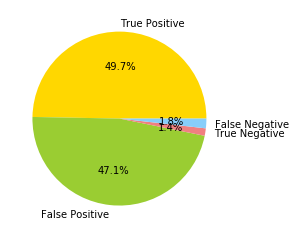

Matriz de confusión: TP: 830|FP: 787|TN: 23|FN: 30|


In [24]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

final_classifier = MLPClassifier(solver='sgd',hidden_layer_sizes=(best_neurons,), 
                                 activation = "relu", alpha=0, learning_rate_init = 0.01)
final_classifier.fit(X_train, y_train)

print("Probabilidad de error del modelo con %s neuronas en una capa escondida: %s" 
      % (best_neurons, 1-final_classifier.score(X_test, y_test)))

tp, fp, tn, fn = confusion_matrix(final_classifier, X_test, y_test)
print("Matriz de confusión: TP: %s|FP: %s|TN: %s|FN: %s|" % (tp, fp, tn, fn))


In [25]:
#Ahora, se toma el número de neuronas con mayor desempeño en una capa escondida y, con este número de neuronas, 
#se prueban n capas escondidas entre 2 y 100 a intervalos de 5.

kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 20
hl_scores = []
best_layers=0
best_score=1

hid_tuple = ()

for n in range(2, n_max+1, 1):
    
    #Ahora expande la tupla, insertando best_neurons n veces hasta llegar a n
    
    hid_tuple = list(hid_tuple)
    while len(hid_tuple) != n:
        hid_tuple.append(best_neurons)
    
    hid_tuple = tuple(hid_tuple)

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_validate = X_train[train_index], X_train[test_index]
        y_train_cv, y_validate = y_train[train_index], y_train[test_index]
        net = MLPClassifier(solver='sgd', hidden_layer_sizes=hid_tuple, 
                           activation = "relu", alpha=0, learning_rate_init = 0.01)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    hl_scores.append(score)
    
    if score < best_score:
        best_score = score
        best_layers = n
    
    print("Average error probability for %s neurons in %s hidden layers: %s" % (best_neurons, n,score))
    
    
print("Lowest error probability: %s for model with %s hidden layers" % (best_score, best_layers))



Average error probability for 42 neurons in 2 hidden layers: 0.48038922155688624
Average error probability for 42 neurons in 3 hidden layers: 0.4794910179640719
Average error probability for 42 neurons in 4 hidden layers: 0.48038922155688624
Average error probability for 42 neurons in 5 hidden layers: 0.4827844311377246
Average error probability for 42 neurons in 6 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 7 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 8 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 9 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 10 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 11 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 12 hidden layers: 0.4799401197604791
Average error probability for 42 neurons in 13 hidden layers: 0.4799401197604791
Average error probability for 42 n

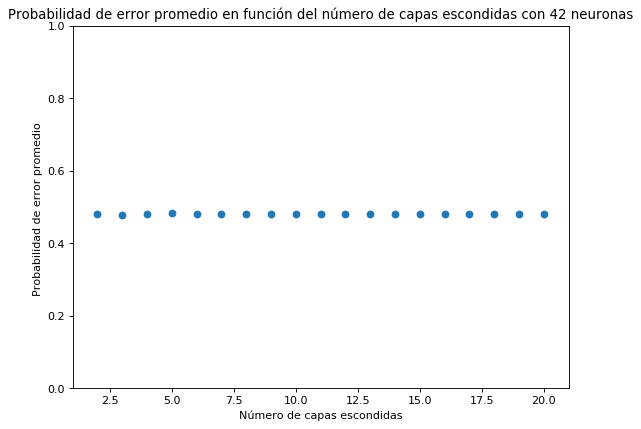

In [26]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(2, n_max+1, 1), hl_scores, 'o')
plt.axis([1, 21, 0, 1])
plt.xlabel('Número de capas escondidas')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número de capas escondidas con %s neuronas' 
          % best_neurons)
plt.show()

Probabilidad de error del modelo con 42 neuronas en 3 capas escondida: 0.4850299401197605


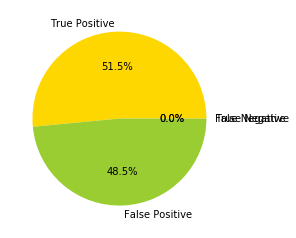

TP: 860|FP: 810|TN: 0|FN: 0|


In [27]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

hid_tuple_final = ()
hid_tuple_final = list(hid_tuple_final)

while len(hid_tuple_final) != best_layers:
    hid_tuple_final.append(best_neurons)
    
hid_tuple_final = tuple(hid_tuple_final)

final_classifier = MLPClassifier(solver='sgd',hidden_layer_sizes=hid_tuple_final, 
                                 activation = "relu", alpha=0, learning_rate_init = 0.01)
final_classifier.fit(X_train, y_train)

print("Probabilidad de error del modelo con %s neuronas en %s capas escondida: %s" 
      % (best_neurons, best_layers, 1-final_classifier.score(X_test, y_test)))

tp, fp, tn, fn = confusion_matrix(final_classifier, X_test, y_test)
print("TP: %s|FP: %s|TN: %s|FN: %s|" % (tp, fp, tn, fn))

De aquí en adelante es "Machete", intentar con un número obsceno de neuronas, PCA, etc...

Pareciera que no hay forma de "partir" los datos con una serie de hiperplanos, parece que la red aprende a siempre predecir la clase de mayor frecuencia para, así, minimizar su error.

In [28]:
net = MLPClassifier(solver='sgd', activation = "relu", alpha=0,
                    hidden_layer_sizes=(8000,), learning_rate_init = 0.01)
net.fit(X_train,y_train)
print("Train set error probability: %s" % (1 - net.score(X_train, y_train)))
print("Test set error probability: %s" % (1 - net.score(X_test, y_test)))

Train set error probability: 0.479940119760479
Test set error probability: 0.4850299401197605


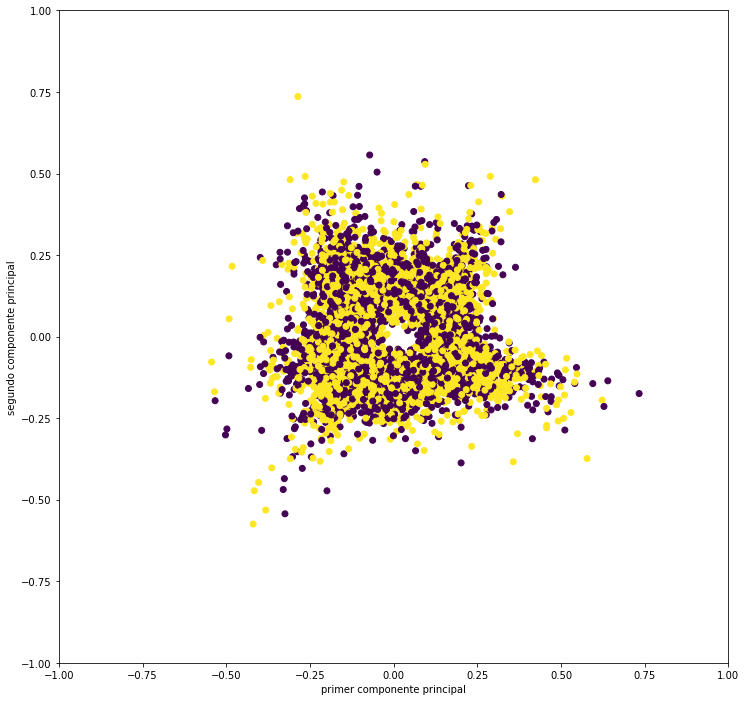

In [21]:
#intentar ver si PCA ayuda en algo
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

#graficar datos en 2D tras reducción de dimensionalidades
plt.figure(figsize=(12, 12))
dic ={
    'a': X_pca[:,0],
    'b': X_pca[:,1],
    'c': y
}

plt.scatter('a','b', c = 'c', data = dic)
plt.axis([-1, 1, -1, 1])
plt.xlabel('primer componente principal')
plt.ylabel('segundo componente principal')
plt.show()

In [34]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = percentage_test) 

kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 100
scores = []
best_neurons=0
best_score=1

for n in range(2, n_max+1, 5):

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X_train_pca):
        X_train_cv, X_validate = X_train_pca[train_index], X_train_pca[test_index]
        y_train_cv, y_validate = y_train_pca[train_index], y_train_pca[test_index]
        net = MLPClassifier(solver='sgd' ,hidden_layer_sizes=(n,),
                            activation = "relu", alpha=0, learning_rate_init = 0.01)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_neurons = n
    
    print("Average error probability for %s neurons in one hidden layer: %s" % (n, score))

print("Lowest error probability: %s for model with %s neurons" % (best_score, best_neurons))

Average error probability for 2 neurons in one hidden layer: 0.48592814371257487
Average error probability for 7 neurons in one hidden layer: 0.4776946107784432
Average error probability for 12 neurons in one hidden layer: 0.48203592814371266
Average error probability for 17 neurons in one hidden layer: 0.4776946107784432
Average error probability for 22 neurons in one hidden layer: 0.4805389221556886
Average error probability for 27 neurons in one hidden layer: 0.4812874251497006
Average error probability for 32 neurons in one hidden layer: 0.4799401197604791
Average error probability for 37 neurons in one hidden layer: 0.47964071856287427
Average error probability for 42 neurons in one hidden layer: 0.47874251497005993
Average error probability for 47 neurons in one hidden layer: 0.47964071856287427
Average error probability for 52 neurons in one hidden layer: 0.47874251497005993
Average error probability for 57 neurons in one hidden layer: 0.4818862275449102
Average error probabilit

Probabilidad de error del modelo con 7 neuronas en una capa escondida: 0.4880239520958084


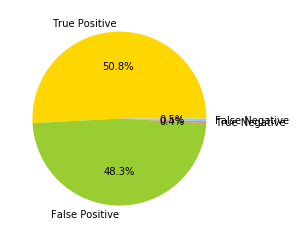

Matriz de confusión: TP: 849|FP: 807|TN: 6|FN: 8|


In [35]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

final_classifier = MLPClassifier(solver='sgd',hidden_layer_sizes=(best_neurons,), 
                                 activation = "relu", alpha=0, learning_rate_init = 0.01)
final_classifier.fit(X_train_pca, y_train_pca)

print("Probabilidad de error del modelo con %s neuronas en una capa escondida: %s" 
      % (best_neurons, 1-final_classifier.score(X_test_pca, y_test_pca)))

tp, fp, tn, fn = confusion_matrix(final_classifier, X_test_pca, y_test_pca)
print("Matriz de confusión: TP: %s|FP: %s|TN: %s|FN: %s|" % (tp, fp, tn, fn))

In [36]:
#Ahora, se toma el número de neuronas con mayor desempeño en una capa escondida y, con este número de neuronas, 
#se prueban n capas escondidas entre 2 y 100 a intervalos de 5.

kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 20
hl_scores = []
best_layers=0
best_score=1

hid_tuple = ()

for n in range(2, n_max+1, 1):
    
    #Ahora expande la tupla, insertando best_neurons n veces hasta llegar a n
    
    hid_tuple = list(hid_tuple)
    while len(hid_tuple) != n:
        hid_tuple.append(best_neurons)
    
    hid_tuple = tuple(hid_tuple)

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X_train_pca):
        X_train_cv, X_validate = X_train_pca[train_index], X_train_pca[test_index]
        y_train_cv, y_validate = y_train_pca[train_index], y_train_pca[test_index]
        net = MLPClassifier(solver='sgd', hidden_layer_sizes=hid_tuple, 
                           activation = "relu", alpha=0, learning_rate_init = 0.01)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    hl_scores.append(score)
    
    if score < best_score:
        best_score = score
        best_layers = n
    
    print("Average error probability for %s neurons in %s hidden layers: %s" % (best_neurons, n,score))
    
    
print("Lowest error probability: %s for model with %s hidden layers" % (best_score, best_layers))

Average error probability for 7 neurons in 2 hidden layers: 0.48383233532934145
Average error probability for 7 neurons in 3 hidden layers: 0.47979041916167664
Average error probability for 7 neurons in 4 hidden layers: 0.47904191616766467
Average error probability for 7 neurons in 5 hidden layers: 0.47919161676646715
Average error probability for 7 neurons in 6 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 7 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 8 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 9 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 10 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 11 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 12 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 13 hidden layers: 0.4794910179640719
Average error probability for 7 neurons in 1

Probabilidad de error del modelo con 7 neuronas en 4 capas escondida: 0.4868263473053892


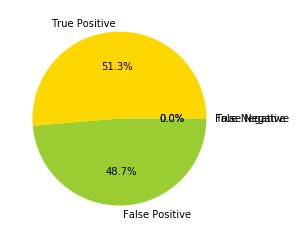

TP: 857|FP: 813|TN: 0|FN: 0|


In [38]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

hid_tuple_final = ()
hid_tuple_final = list(hid_tuple_final)

while len(hid_tuple_final) != best_layers:
    hid_tuple_final.append(best_neurons)
    
hid_tuple_final = tuple(hid_tuple_final)

final_classifier = MLPClassifier(solver='sgd',hidden_layer_sizes=hid_tuple_final, 
                                 activation = "relu", alpha=0, learning_rate_init = 0.01)
final_classifier.fit(X_train_pca, y_train_pca)

print("Probabilidad de error del modelo con %s neuronas en %s capas escondida: %s" 
      % (best_neurons, best_layers, 1-final_classifier.score(X_test_pca, y_test_pca)))

tp, fp, tn, fn = confusion_matrix(final_classifier, X_test_pca, y_test_pca)
print("TP: %s|FP: %s|TN: %s|FN: %s|" % (tp, fp, tn, fn))